In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## EDA

### load merged df

In [2]:
df_raw = pd.read_csv('/Users/gawain/Desktop/1. Machine-Learning/TMDB 5000 Movie/tmdb_5000_movie_data/original_merge_df.csv', index_col=0)
df = df_raw.copy()
indices = pd.Series(df_raw.index, index=df_raw['title_full'])


### data cleaning

In [3]:
#  only keep the 'title_full' as some 'original_title' is not english, which is not good for further training
df = df.drop(columns = ['original_title'])
df.head(1)

,title_full,cast,crew,budget,genres,homepage,keywords,original_language,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
# remove missing values
df = df.drop(columns = ['homepage','tagline'])
df = df.dropna()
df.isnull().sum().sum()

0

### useful tool

In [5]:
def name_convert(x):
      L = []
      count = 0
      for i in literal_eval(x):
            if count != 5:
                  L.append(i['name'])
                  count += 1
            else:
                  break
      return L

In [6]:
def character_convert(x):
      L = []
      count = 0
      for i in literal_eval(x):
            if count != 5:
                  L.append(i['character'])
                  count += 1
            else:
                  break
      return L

In [7]:
def fetch_director(x):
      L = []
      for i in literal_eval(x):
            if i['job'] == 'Director':
                  return i['name']
      return np.nan

In [8]:
def fetch_screenplay(x):
      L = []
      count = 0
      for i in literal_eval(x):
            if count != 5:
                  if i['job'] =='Screenplay':
                        L.append(i['name'])
                        count += 1
            else:
                  break
      return L

In [9]:
def remove_duplicates(x):
      seen = set()
      result = []
      for item in x:
            if item not in seen:
                  seen.add(item)
                  result.append(item)
      return result

### features' selection

In [10]:
# feature1: cast -> keep name & character
df['cast_name'] = df['cast'].apply(name_convert)
df['cast_character'] = df['cast'].apply(character_convert)
df[['cast_name', 'cast_character']].head(2)

,cast_name,cast_character
id,,
19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Jake Sully, Neytiri, Dr. Grace Augustine, Col..."
285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Captain Jack Sparrow, Will Turner, Elizabeth ..."


In [11]:
### feature 2: crew -> keep director & screenplay
# Every movie is built by various parts, but director and screenplay take the most important position though the whole production. 
# A good screenwriter will bring up a supersizing breaking point in the movie, while the director will visualize it 
# So we will keep Director and Screenplay.
df['director'] = df['crew'].apply(fetch_director)
df['screenwriter'] = df['crew'].apply(fetch_screenplay)

# Though we have the director and screenwriter, but we notice that sometimes director can also be screenwriter.
# For this case, we need to drop the duplicate name, and preserve the order
df['screenwriter'] = df['screenwriter'].apply(remove_duplicates)
df.iloc[3]['screenwriter']

['Christopher Nolan', 'Jonathan Nolan']

In [12]:
# feature 3: genres -> keep name
df['genres'] = df['genres'].apply(name_convert)
df.iloc[3]['genres']

['Action', 'Crime', 'Drama', 'Thriller']

In [13]:
# feature 4: keyword -> keep name
df['keywords'] = df['keywords'].apply(name_convert)
df.iloc[3]['keywords']

['dc comics', 'crime fighter', 'terrorist', 'secret identity', 'burglar']

In [14]:
# # features can be dropped:
df = df.drop(columns = ['original_language',
                        'production_companies',
                        'production_countries',
                        'release_date',                 
                        'revenue',            
                        'spoken_languages',
                        'cast',
                        'crew',
                        'budget',
                        'title'
                        ]         
                  )
df.head(3)

,title_full,genres,keywords,overview,popularity,runtime,status,vote_average,vote_count,cast_name,cast_character,director,screenwriter
id,,,,,,,,,,,,,
19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",150.437577,162.0,Released,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Jake Sully, Neytiri, Dr. Grace Augustine, Col...",James Cameron,[James Cameron]
285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",139.082615,169.0,Released,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Captain Jack Sparrow, Will Turner, Elizabeth ...",Gore Verbinski,"[Ted Elliott, Terry Rossio]"
206647,Spectre,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi6]",A cryptic message from Bond’s past sends him o...,107.376788,148.0,Released,6.3,4466,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[James Bond, Blofeld, Madeleine, M, Lucia]",Sam Mendes,"[John Logan, Robert Wade, Neal Purvis, Jez But..."


### data explore

In [15]:
def get_genre_count(df):
      c = df.genres.values
      l = []
      for k, v in enumerate(c):
            l.append(v)

      genres = Counter()
      for i in range(len(l)):
            for j in l[i]:
                  genres[j] += 1
      Genres_df = pd.DataFrame.from_dict(genres, orient='index').reset_index()
      Genres_df = Genres_df.rename(columns = {'index': 'Genres' ,0: 'Count'})   
      # Genres_df = Genres_df.sort_values(by = 'Count', ascending = False)

      return Genres_df

In [16]:
genre_df = get_genre_count(df)
genre_df.head(10)

,Genres,Count
0,Action,1153
1,Adventure,790
2,Fantasy,418
3,Science Fiction,530
4,Crime,696
5,Drama,2296
6,Thriller,1259
7,Animation,234
8,Family,510
9,Western,80


Text(0, 0.5, 'Count')

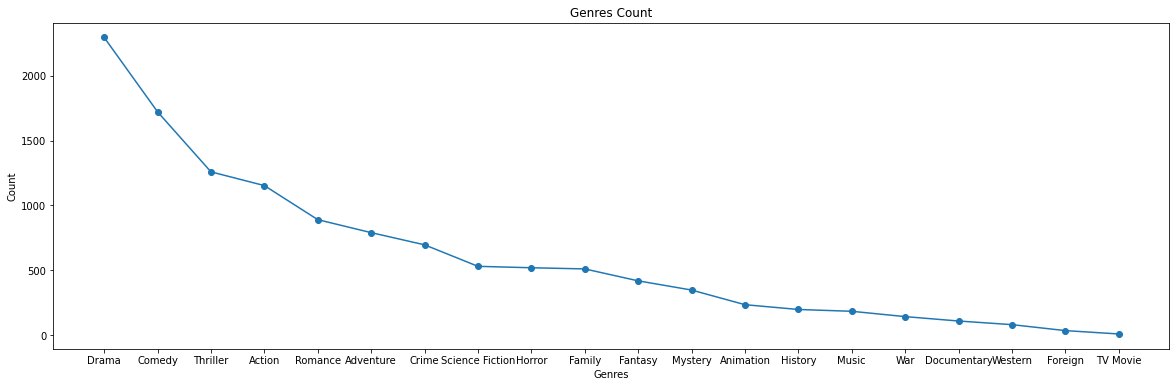

In [17]:
genre_df = genre_df.sort_values(by = 'Count', ascending = False)
plt.figure(figsize=(20,6))
plt.plot(genre_df.Genres, genre_df.Count, marker = 'o')
plt.title('Genres Count')
plt.xlabel('Genres')
plt.ylabel('Count')

In [18]:
#Building new data frame
genres_list = genre_df.Genres.tolist()
df_new = df[['title_full' , 'genres' , 'popularity']]
df_new[genres_list] =0

/Users/gawain/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value


In [19]:
df_new.head(1)

,title_full,genres,popularity,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,...,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie
id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",150.437577,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure',
            'Crime', 'Science Fiction', 'Horror', 'Family', 'Fantasy',
            'Mystery', 'Animation', 'History', 'Music', 'War', 'Documentary',
            'Western', 'Foreign', 'TV Movie'
            ]
for i in test:
      if i in df.iloc[3]['genres']:
            print(i)
print(df.iloc[3]['genres'])

Drama
Thriller
Action
Crime
['Action', 'Crime', 'Drama', 'Thriller']


In [21]:
#  convert the genres to dummy variables
df_title_popu = df_new[['title_full', 'popularity']]
genres_dummy = df_new.drop(columns = ['title_full','genres','popularity'])
for i in range(genres_dummy.shape[0]):
      for j in df.iloc[i]['genres']:
            genres_dummy.iloc[i][j] = 1
df_f_cluster = pd.concat([df_title_popu, genres_dummy], axis = 1)

dataset = df_f_cluster.drop(columns = ['title_full','popularity'])
dataset.head(3)

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie
id,,,,,,,,,,,,,,,,,,,,
19995,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
285,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
206647,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
print(df_f_cluster.shape)
print(dataset.shape)

(4799, 22)
(4799, 20)


now we have the df with genres' dummy variables, we will put them into the clustering model

## clustering by K-mean

In [23]:
#decomposing the features in 2d
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dataset)

#clustring using Kmean  - sklearn
model = KMeans(n_clusters=50)
model.fit(principalComponents)
labels = model.labels_
df_label = pd.DataFrame({'label':labels})

In [24]:
df_label[:10]

,label
0,6
1,42
2,19
3,11
4,6
5,42
6,40
7,6
8,14
9,42


In [25]:
df_label.isnull().sum()
print(df_label.shape)

(4799, 1)


In [26]:
df_f_cluster.reset_index(drop=True, inplace=True)
#*  make sure you need to re-set the index of 'df_f_cluster', otherwise the index will be mixed up and will has NaN value in 'label' column after joining with 'df_label'
df_result = df_f_cluster.join(df_label)

In [27]:
#Build the Recommendation Function
def get_recommendations_by_clustering(film):
      global df_result
      df_result = df_result.sort_values(by = 'popularity' , ascending = False)
      mark = df_result.loc[df_result['title_full'] == film, 'label'].iloc[0]
      print ("Label number : "  , mark)
      print ("_"*40)
      print ("\nRecommended movies for {} : ".format(film))
      print ("_"*40)
      lst = df_result[df_result.label == mark]['title_full'][0:10].tolist()
      for n , l in zip (range (1,11) , lst):
            print ( n , " : " , l)

In [28]:
get_recommendations_by_clustering('The Dark Knight Rises')

Label number :  11
________________________________________

Recommended movies for The Dark Knight Rises : 
________________________________________
1  :  The Dark Knight
2  :  The Dark Knight Rises
3  :  The Bourne Identity
4  :  Run All Night
5  :  Scarface
6  :  Oldboy
7  :  Sicario
8  :  Need for Speed
9  :  Training Day
10  :  Drive


##  build Item-Based Filtering model

since we have the recommend sys powered by the 'genres' feature. 

We should realize there are many other features can be used for the improvement.

Now we will focus on:

(item-based)

- title_full 
- cast_character
- director
- screenwriter (optional)


According to the experience I search movie, user-based movie is the most easy method I would use to search as find a 'popular' one is majorly based on others' review.

However, user-based method will make me miss many good ones which is not popular(lack of review) by many chances, so item-based method will help improve the model get the correlation b/w various movies, and will give me a 'supersizing' result sometimes, which is exactly I would like to use as a deep fan.

In [29]:
df.head(1)

,title_full,genres,keywords,overview,popularity,runtime,status,vote_average,vote_count,cast_name,cast_character,director,screenwriter
id,,,,,,,,,,,,,
19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",150.437577,162.0,Released,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Jake Sully, Neytiri, Dr. Grace Augustine, Col...",James Cameron,[James Cameron]


### useful tool

In [30]:
# convert string into lowercase
def clean_string(x):
      if isinstance(x, list):
            return [str.lower(i.replace(" "," ")) for i in x]
      else:
            if isinstance(x, str):
                  return str.lower(x.replace(" ", " "))
            else:
                  return ''

I tried the soup with 'overview' added, and  show the unexpected result as the content in 'overview' will make the targeted words more significant.

The content of the overview from 'The Dark Knight Rises':

            action crime drama thriller christopher nolan christian bale michael caine gary oldman anne hathaway tom hardybruce wayne / batman alfred pennyworth james gordon selina kyle / catwoman banechristopher nolan jonathan nolandc comics crime fighter terrorist secret identity burglar following the death of district attorney harvey dent, batman assumes responsibility for dent's crimes to protect the late attorney's reputation and is subsequently hunted by the gotham city police department. eight years later, batman encounters the mysterious selina kyle and the villainous bane, a new terrorist leader who overwhelms gotham's finest. the dark knight resurfaces to protect a city that has branded him an enemy.

The result of 'The Dark Knight Rises' through the recommend sys by similarity will bring up most movie related to a series of 'Batman'

            The Dark Knight Rises ->>
            65                              The Dark Knight
            119                               Batman Begins
            428                              Batman Returns
            1359                                     Batman
            299                              Batman Forever
            1196                               The Prestige
            210                              Batman & Robin
            1664                              Dead Man Down
            3853    Batman: The Dark Knight Returns, Part 2
            4634                   Amidst the Devil's Wings

***So I decide to exclude the feature 'overview'***

In [31]:
def create_soup(x):
      return ' '.join(x['genres'])  + ' ' + x['director'] + ' ' + ' '.join(x['cast_name']) + ' '.join(x['cast_character']) + ' '.join(x['screenwriter'])+ ' '.join(x['keywords'])

In [32]:
# 定义输入电影名称，输出与之最相似的电影的函数
def get_recommendations_by_similarity(title, cosine_sim):
      idx = indices[title]
      
      # 获取所有电影与该电影的相似度得分
      sim_score= list(enumerate(cosine_sim[idx]))
      
      # 根据相似度得分对电影进行排序
      sim_score_sorted = sorted(sim_score, key = lambda x: x[1], reverse=True)
      
      # 获取10部最相似的电影的相似度得分
      sim_score_top_10 = sim_score_sorted[1:11]
      
      # 获取电影索引
      movie_indices = [i[0] for i in sim_score_top_10]
      
      # 返回10部最相似的电影
      return df['title_full'].iloc[movie_indices]

### feature engineering

In [33]:
df = df.reset_index()
indices = pd.Series(df.index, index = df['title_full'])

features_str = ['genres', 'keywords','director','cast_name','cast_character','director','screenwriter']
for feature in features_str:
      df[feature] = df[feature].apply(clean_string)
      
df[features_str].head()

,genres,keywords,director,cast_name,cast_character,director,screenwriter
0,"[action, adventure, fantasy, science fiction]","[culture clash, future, space war, space colon...",james cameron,"[sam worthington, zoe saldana, sigourney weave...","[jake sully, neytiri, dr. grace augustine, col...",james cameron,[james cameron]
1,"[adventure, fantasy, action]","[ocean, drug abuse, exotic island, east india ...",gore verbinski,"[johnny depp, orlando bloom, keira knightley, ...","[captain jack sparrow, will turner, elizabeth ...",gore verbinski,"[ted elliott, terry rossio]"
2,"[action, adventure, crime]","[spy, based on novel, secret agent, sequel, mi6]",sam mendes,"[daniel craig, christoph waltz, léa seydoux, r...","[james bond, blofeld, madeleine, m, lucia]",sam mendes,"[john logan, robert wade, neal purvis, jez but..."
3,"[action, crime, drama, thriller]","[dc comics, crime fighter, terrorist, secret i...",christopher nolan,"[christian bale, michael caine, gary oldman, a...","[bruce wayne / batman, alfred pennyworth, jame...",christopher nolan,"[christopher nolan, jonathan nolan]"
4,"[action, adventure, science fiction]","[based on novel, mars, medallion, space travel...",andrew stanton,"[taylor kitsch, lynn collins, samantha morton,...","[john carter, dejah thoris, sola, tars tarkas,...",andrew stanton,"[andrew stanton, michael chabon, mark andrews]"


In [34]:
df['soup'] = df.apply(create_soup, axis=1)
df['soup'].head(3)

0    action adventure fantasy science fiction james...
1    adventure fantasy action gore verbinski johnny...
2    action adventure crime sam mendes daniel craig...
Name: soup, dtype: object

In [35]:
df.iloc[3]['soup']

'action crime drama thriller christopher nolan christian bale michael caine gary oldman anne hathaway tom hardybruce wayne / batman alfred pennyworth james gordon selina kyle / catwoman banechristopher nolan jonathan nolandc comics crime fighter terrorist secret identity burglar'

In [36]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [37]:
title_test = 'The Dark Knight Rises'
idx_test = indices[title_test]
print('The re-set index of The Dark Knight Rises is: ',idx_test,'\n')

sim_score_test = list(enumerate(cosine_sim[idx_test]))
sim_score_sorted_test = sorted(sim_score_test, key = lambda x: x[1], reverse=True)
print(sim_score_sorted_test[:10])
#  we used cosine similarity to find the most similar movie to 'The Dark Knight Rises'

The re-set index of The Dark Knight Rises is:  3 

[(3, 1.0000000000000004), (65, 0.6324555320336759), (119, 0.6000000000000002), (1196, 0.39131189606246325), (4634, 0.3651483716701108), (428, 0.3379189091915236), (1359, 0.30779350562554625), (2792, 0.2598076211353316), (3325, 0.23596995186213465), (210, 0.23312620206007847)]


### get recomment by similarity

In [38]:
get_recommendations_by_similarity('The Dark Knight Rises', cosine_sim)

65               The Dark Knight
119                Batman Begins
1196                The Prestige
4634    Amidst the Devil's Wings
428               Batman Returns
1359                      Batman
2792        The Killer Inside Me
3325              Black November
210               Batman & Robin
95                  Interstellar
Name: title_full, dtype: object

## Collaborative Filtering

based on the users' preference (rating in this case)


In [39]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [40]:
reader = Reader()
rating = pd.read_csv('/Users/gawain/Desktop/1. Machine-Learning/TMDB 5000 Movie/movie_dataset/ratings_small.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [42]:
pivot_df = pd.pivot_table(rating, index = 'userId', columns = 'movieId', values = 'rating')
pivot_df.fillna(0, inplace = True)
print(pivot_df.shape)
pivot_df.head()

(671, 9066)


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161155,161594,161830,161918,161944,162376,162542,162672,163949,user_index
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [44]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual rating given by user
pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD method

reference：

https://www.kaggle.com/code/saurav9786/recommendation-based-on-amazon-food-review

1. make pivot-table
2. svds() construct three values
3. get prediction scores
4. recommend func

In [45]:
from scipy.sparse.linalg import svds

In [46]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50) # K: Number of singular values and vectors to compute
# Construct diagonal array in SVD
sigma = np.diag(sigma) 

In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Predicted rating
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.057419,0.044156,-0.003525,-0.014026,-0.011693,0.037647,-0.011436,-0.012794,0.017412,0.037456,...,-0.001519,0.000171,0.016497,0.000130,0.000195,-0.013686,0.024746,-0.000700,-0.000420,-0.003038
1,0.397099,1.422453,-0.175735,0.166606,0.269432,0.385791,0.068086,0.043673,-0.004759,2.241940,...,-0.002005,0.000998,-0.007596,0.000552,0.000828,-0.059196,-0.011395,0.005804,0.003482,-0.004010
2,1.275403,0.296807,0.033442,-0.010834,0.100854,0.062972,-0.088911,0.009645,-0.002955,0.227495,...,-0.002610,-0.004553,-0.011604,0.000279,0.000419,-0.008031,-0.017406,0.008379,0.005027,-0.005219
3,1.183095,1.016435,0.105598,0.074721,-0.337196,-1.433923,-0.337587,-0.154619,-0.056599,1.551431,...,0.023616,0.008438,0.058714,0.003375,0.005062,0.150868,0.088071,-0.023062,-0.013837,0.047233
4,1.338518,1.510306,0.655975,-0.030616,0.764755,-0.159291,0.009004,0.054437,-0.134904,0.396755,...,0.001700,-0.000225,0.016028,0.006308,0.009463,-0.005235,0.024042,0.013163,0.007898,0.003400


In [48]:
# recommend the item with the top 10 predicted rating
def recommend_movie_by_svd(user_id, pivot_df = pivot_df, preds_df = preds_df, df = df, num_recommendations = 10):
      recommend_movie = []
      user_idx = user_id - 1 # start at 0
      
      pred1 = preds_df.iloc[user_idx].sort_values(ascending = False)[:10] 
      movie_index = pred1.index.to_list()
      for i in movie_index:
            movie_name = df[df.index == int(i)].title_full.values[0]
            recommend_movie.append(movie_name)
      print('\nBelow are the recommended items for user(user_id = {}):\n'.format(user_id))
      for i in range(len(recommend_movie)):
            print('Movie ID: {}  {}'.format(movie_index[i], recommend_movie[i]))


In [49]:
recommend_movie_by_svd(4)


Below are the recommended items for user(user_id = 4):

Movie ID: 1196  The Prestige
Movie ID: 1198  Escape from Planet Earth
Movie ID: 1097  Big Trouble
Movie ID: 1240  The Other Boleyn Girl
Movie ID: 1200  The Living Daylights
Movie ID: 1210  Gothika
Movie ID: 1136  Hero
Movie ID: 260  Ender's Game
Movie ID: 1197  Horrible Bosses 2
Movie ID: 1291  The Time Traveler's Wife


## Conclusion
Here we finish all three methods for the recommend system:

1. Clustering method(K-mean)
2. Similarity item-based filtering
3. Collaborative Filtering(rating)

Feel free to comment.

Thanks for reading and please upvote.